In [49]:
%load_ext autoreload
%autoreload 2



import sys, os
sys.path.append("../")

import numpy as np
import math
import pickle
from config import *
from iotools.readOxford import ReadOxford
from iotools.readrpkm import ReadRPKM
from iotools.io_model import WriteModel
from inference.linreg_association import LinRegAssociation
from inference.empirical_bayes import EmpiricalBayes
from utils import hyperparameters
from inference import logmarglik
from iotools import readgtf
from utils import gtutils
from utils import mfunc
from utils.containers import ZstateInfo
from utils.printstamp import printStamp
from helper_functions import load_target_genes, write_params
from sklearn.preprocessing import scale

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Annotation (use complete gene name in gtf without trimming the version)
# load annotation for whole genome
gene_info = readgtf.gencode_v12(gtfpath, trim=False)

In [3]:

# Load gene list
genelistfile = "genes4testing_high_and_low_r2_0.001"
selected_gene_ids = load_target_genes(genelistfile, gene_info, chrom)


Read 641 genes with high r2 values

Found 57 genes in CHR 12


In [4]:


if not os.path.exists(learn_pickfile):
    # read Genotype
    oxf = ReadOxford(gtex_gtpath, gtex_samplepath, chrom, learning_dataset)
    genotype = np.array(oxf.dosage)
    samplenames = oxf.samplenames
    snps = oxf.snps_info

    printStamp("Dumping CHR {:d} genotype".format(chrom))
    with open(learn_pickfile, 'wb') as output:
        pickle.dump(oxf, output, pickle.HIGHEST_PROTOCOL)
else:
    printStamp("Reading pickled genotype")
    with open(learn_pickfile, 'rb') as input:
        pickled_oxf = pickle.load(input)

    printStamp("Done reading")

    genotype = np.array(pickled_oxf.dosage)
    samplenames = pickled_oxf.samplenames
    snps = pickled_oxf.snps_info
    nsample = len(pickled_oxf.samplenames)

# Quality control
f_snps, f_genotype = gtutils.remove_low_maf(snps, genotype, 0.1)
gt = gtutils.normalize(f_snps, f_genotype)

# Gene Expression
rpkm = ReadRPKM(gtex_rpkmpath, "gtex")
expression = rpkm.expression
expr_donors = rpkm.donor_ids
gene_names = rpkm.gene_names

# Selection
printStamp("Selection of samples")
vcfmask, exprmask = mfunc.select_donors(samplenames, expr_donors)
genes, indices = mfunc.select_genes(gene_info, gene_names)

gene_training_list = []
for i, gene in enumerate(genes):
    k = indices[i]
    if gene.ensembl_id in selected_gene_ids and gene.chrom == chrom:
        gene_training_list.append((k,gene))
        # print(k,gene)

2018-03-24 14:35:30 - Reading pickled genotype
2018-03-24 14:35:33 - Done reading
2018-03-24 14:35:40 - Selection of samples


In [8]:
parameters[0]

['gxpred-bslmm',
 [0.1, 0.0, 0.01, 0.1, 0.005],
 [None, None, None, None, None],
 {'Galpha': 2, 'Gbeta': 0.5, 'lambda': 0.05},
 'trans_eQTLs_NoPriors']

In [ ]:

p = parameters[0]

prior = p[0]
params = p[1]
hyperpriors = p[2]
hyperparams = p[3]
run_description = p[4]
init_params = np.array(params)
# account for Tau inverse value
init_params[4] = 1 / init_params[4] / init_params[4]

model_dir = prior+"_{:.3f}_{:.3f}_{:.3f}_{:.3f}_{:.3f}".format(params[0], params[1], params[2], params[3], params[4])
modelpath = os.path.join("./z"+str(zmax), run_description, model_dir)
write_params(modelpath, p)

model = WriteModel(modelpath, chrom)

for i in range(0,len(gene_training_list)):
# for i in range(0,1):

    k, gene = gene_training_list[i]
    
    print(k, gene)
    
    trans_snps_file = os.path.join("transeqtls", "geno_genes", "geno."+gene.ensembl_id.split(".")[0]+".snp.gz")
    if os.path.exists(trans_snps_file):
        print("Gene {:s} has transqtls!".format(gene.ensembl_id))
    else:
        print("No trans!")


    # Load trans-eQTLs for gene, if exists
    trans_oxf = ReadOxford(trans_snps_file, gtex_samplepath, chrom, learning_dataset)
    trans_genotype = np.array(trans_oxf.dosage)
    trans_snps = trans_oxf.snps_info
    
    
    # select only the cis-SNPs
    cismask = mfunc.select_snps(gene, f_snps, window)
    if len(cismask) > 0:
        target = expression[k, exprmask]
        target = scale(target, with_mean=True, with_std=True)
        predictor = gt[cismask][:, vcfmask]
        snpmask = cismask

        # if number of cis SNPs > threshold, use p-value cut-off
        if len(cismask) > min_snps:
            assoc_model = LinRegAssociation(predictor, target, min_snps, pval_cutoff)
            pvalmask = cismask[assoc_model.selected_variables]
            print ("Found {:d} SNPs, reduced to {:d} SNPs (max p-value {:g}) for {:s}".format(len(cismask), len(pvalmask), assoc_model.ordered_pvals[len(pvalmask) - 1], gene.name))
            predictor = gt[pvalmask][:, vcfmask]
            snpmask = pvalmask
        else:
            print ("Found {:d} SNPs for {:s}".format(len(cismask), gene.name))

            
        # add trans-eQTLs
        transSNPs = trans_genotype[:,vcfmask]
        predictor = np.concatenate((predictor, transSNPs), axis=0)
        
        # perform the analysis

        print ("Starting first optimization ==============")
        emp_bayes = EmpiricalBayes(predictor, target, 1, init_params, method="new", prior=prior, hyperpriors= hyperpriors, hyperparams= hyperparams)
        emp_bayes.fit()
        if zmax > 1:
            if emp_bayes.success:
                res = emp_bayes.params
                print ("Starting second optimization from previous results ================")
                # Python Error: C library could not compute z-components. Check C errors above.
            else:
                res = init_params
                print ("Starting second optimization from initial parameters ================")
            emp_bayes = EmpiricalBayes(predictor, target, zmax, res, method="new", prior=prior, hyperpriors= hyperpriors, hyperparams= hyperparams)
            emp_bayes.fit()

        if emp_bayes.success:
            res = emp_bayes.params
            res[4] = 1 / np.sqrt(res[4])
            print("PI: \t",res[0])
            print("mu: \t",res[1])
            print("sigma: \t",res[2])
            print("sigmabg: \t",res[3])
            print("tau: \t",res[4])

            model_snps = [f_snps[x] for x in snpmask] + list(trans_snps)
            model_zstates = list()
            scaledparams = hyperparameters.scale(emp_bayes.params)
            zprob, zexp = logmarglik.model_exp(scaledparams, predictor, target, emp_bayes.zstates, prior)
            for j, z in enumerate(emp_bayes.zstates):
                this_zstate = ZstateInfo(state = z,
                                         prob  = zprob[j],
                                         exp   = list(zexp[j, :]) )
                model_zstates.append(this_zstate)
            # print(model_snps)
            # for i,m in enumerate(model_zstates):
            #     print("z-state: ",i," Prob:", m.prob)
            model.write_success_gene(gene, model_snps, model_zstates, res)
        else:
            model.write_failed_gene(gene, np.zeros_like(init_params))
            print ("Failed optimization")


In [ ]:
SNP_COMPLEMENT = {'A':'T', 'C':'G', 'G':'C', 'T':'A'}

def select_snps(snpinfo):
    ''' Find indices of the genotype matrix
        corresponding to the cis SNPs of gene
    '''
    selected_snp = [(i,snp) for i, snp in enumerate(snpinfo) if max(len(snp.ref_allele), len(snp.alt_allele)) == 1]
    indices = [snp[0] for snp in selected_snp if snp[1].alt_allele != SNP_COMPLEMENT[snp[1].ref_allele] and
                                                 max(len(snp[1].ref_allele), len(snp[1].alt_allele)) == 1 and
                                                 snp[1].maf >= 0.1 and snp[1].maf <= 0.9]
    return np.array(indices)

ix = select_snps(trans_snps)
result = [trans_snps[i] for i in ix]

# Prediction

In [106]:

import sys
sys.path.append("../")
import os
import pickle
from utils.printstamp import printStamp
from iotools.io_model import ReadModel
from utils.containers import GeneExpressionArray
from utils import gtutils
from utils import mfunc
import numpy as np
from config import *

In [ ]:
# forget about it, Anubhav says there's no overlap between transeQTLs in gtex and cardiogenics

# def compile_trans_snps(snp_list, chrom):
#     gtpath=os.path.join(reference_home, "genotypes/CG_"+str(chrom)+".imputed.gz")
#     with gzip.open(gtpath, 'r') as filereader:
#         for snpline in filereader:
#             mline = snpline.split()
#             varid = mline[1]
#             bp_pos = mline[2]
#             if varid in snp_list:
                

In [107]:

# Read GTEx genotype, since trans-eQTLs are not present in Cardiogenics

if not os.path.exists(learn_pickfile):
    # read Genotype
    oxf = ReadOxford(gtex_gtpath, gtex_samplepath, chrom, learning_dataset)
    genotype = np.array(oxf.dosage)
    samplenames = oxf.samplenames
    snps = oxf.snps_info

    printStamp("Dumping CHR {:d} genotype".format(chrom))
    with open(learn_pickfile, 'wb') as output:
        pickle.dump(oxf, output, pickle.HIGHEST_PROTOCOL)
else:
    printStamp("Reading pickled genotype")
    with open(learn_pickfile, 'rb') as input:
        pickled_oxf = pickle.load(input)

    printStamp("Done reading")

    genotype = np.array(pickled_oxf.dosage)
    samplenames = pickled_oxf.samplenames
    snps = pickled_oxf.snps_info
    nsample = len(pickled_oxf.samplenames)


2018-03-26 20:27:39 - Reading pickled genotype
2018-03-26 20:27:43 - Done reading


In [110]:

# Use parameters from config.py
for p in parameters:
    prior = p[0]
    params = p[1]
    hyperpriors = p[2]
    hyperparams = p[3]
    run_description = p[4]
    model_dir = prior+"_{:.3f}_{:.3f}_{:.3f}_{:.3f}_{:.3f}".format(params[0], params[1], params[2], params[3], params[4])
    modelpath = os.path.join("./z"+str(zmax), run_description, model_dir)

    outfileprefix = os.path.join(modelpath,"gtex_pred_chr"+str(chrom))

    print(modelpath)

    printStamp("Predicting for "+model_dir)
    # Write predictions for each model
    p_model = ReadModel(modelpath, chrom)
    p_genes = p_model.genes
    gx = list()
    for gene in p_genes:

        trans_snps_file = os.path.join("transeqtls", "geno_genes", "geno."+gene.ensembl_id.split(".")[0]+".snp.gz")
        if os.path.exists(trans_snps_file):
            print("Gene {:s} has transqtls!".format(gene.ensembl_id))
        else:
            print("No trans!")

        # Load trans-eQTLs for gene, if exists
        trans_oxf = ReadOxford(trans_snps_file, gtex_samplepath, chrom, learning_dataset)
        trans_genotype = np.array(trans_oxf.dosage)
        trans_snps = trans_oxf.snps_info      
        
        newgenotype = np.concatenate( (genotype, trans_genotype), axis=0)
        newsnps = list(snps) + list(trans_snps)
        
        p_model.read_gene(gene)
        p_model_snps = p_model.snps
        p_model_zstates = p_model.zstates

        x = gtutils.prediction_variables(newsnps, p_model_snps, newgenotype)
        print("Found {:d}/{:d} SNPs for prediction".format(x.shape[0], len(p_model_snps)))
        x = gtutils.normalize(p_model_snps, x)

        ypred = np.zeros(nsample)
        for z in p_model_zstates:
            ypred += z.prob * np.dot(x.T, z.exp)

        gx.append(GeneExpressionArray(geneid = gene.ensembl_id, expr_arr = ypred))


    # Write output
    mfunc.write_gcta_phenotype(outfileprefix, samplenames, gx)

./z1/trans_eQTLs_NoPriors/gxpred-bslmm_0.100_0.000_0.100_0.100_0.005
2018-03-26 20:33:25 - Predicting for gxpred-bslmm_0.100_0.000_0.100_0.100_0.005
Gene ENSG00000151065.9 has transqtls!
2018-03-26 20:33:25 - started reading genotype
Read 95 snps in 450 samples.
2018-03-26 20:33:25 - Finished readings snps
Found 295/295 SNPs for prediction
Gene ENSG00000078237.4 has transqtls!
2018-03-26 20:33:28 - started reading genotype
Read 196 snps in 450 samples.
2018-03-26 20:33:28 - Finished readings snps
Found 396/396 SNPs for prediction
Gene ENSG00000139194.3 has transqtls!
2018-03-26 20:33:33 - started reading genotype
Read 16 snps in 450 samples.
2018-03-26 20:33:33 - Finished readings snps
Found 216/216 SNPs for prediction
Gene ENSG00000173262.7 has transqtls!
2018-03-26 20:33:35 - started reading genotype
Read 52 snps in 450 samples.
2018-03-26 20:33:35 - Finished readings snps
Found 252/252 SNPs for prediction
Gene ENSG00000171860.4 has transqtls!
2018-03-26 20:33:37 - started reading ge

Found 308/308 SNPs for prediction
Gene ENSG00000136003.11 has transqtls!
2018-03-26 20:36:24 - started reading genotype
Read 9 snps in 450 samples.
2018-03-26 20:36:24 - Finished readings snps
Found 209/209 SNPs for prediction
Gene ENSG00000110921.7 has transqtls!
2018-03-26 20:36:28 - started reading genotype
Read 89 snps in 450 samples.
2018-03-26 20:36:28 - Finished readings snps
Found 307/307 SNPs for prediction
Gene ENSG00000111199.6 has transqtls!
2018-03-26 20:36:33 - started reading genotype
Read 31 snps in 450 samples.
2018-03-26 20:36:33 - Finished readings snps
Found 231/231 SNPs for prediction
Gene ENSG00000176871.4 has transqtls!
2018-03-26 20:36:38 - started reading genotype
Read 67 snps in 450 samples.
2018-03-26 20:36:38 - Finished readings snps
Found 267/267 SNPs for prediction
Gene ENSG00000176834.9 has transqtls!
2018-03-26 20:36:42 - started reading genotype
Read 19 snps in 450 samples.
2018-03-26 20:36:42 - Finished readings snps
Found 219/219 SNPs for prediction
G

# Assessment 

In [124]:
import sys
sys.path.append("../")
import os
from iotools import readgtf
from iotools.readrpkm import ReadRPKM
from iotools.readPrediction import ReadPrediction
from scipy.stats import pearsonr
from helper_functions import load_target_genes, write_r2_dataframe, get_common_elements, new_write_predicted_r2, pearson_corr_rowwise
import math
import pickle
from utils.printstamp import printStamp

from config import *

In [125]:

# Load reference dataset Gene Expression
reference_rpkm = ReadRPKM(reference_expdatapath, "cardiogenics")
reference_expression = reference_rpkm.expression
reference_expr_donors = reference_rpkm.donor_ids
reference_gene_names = reference_rpkm.gene_names

In [126]:
# use the selected_gene_ids with high R² values as targets, only those in the selected chrom will appear
selected_gene_ids = load_target_genes(genelistfile, gene_info, chrom)
target_genelist = [g.split(".")[0] for g in selected_gene_ids]
target_donors = reference_expr_donors

Read 641 genes with high r2 values

Found 57 genes in CHR 12


In [127]:

### Predixcan assessment ###

if not os.path.exists(predixcan_pickfile):
    # pxpred_predpath = os.path.join(home, "predictions/cardiogenics/predixcan_predictions_klinikum")
    predixcanpred = ReadPrediction(pxpred_predpath, reference_samplepath, "predixcan", trim=True)

    printStamp("Dumping Predixcan prediction")
    with open(predixcan_pickfile, 'wb') as output:
        pickle.dump(predixcanpred, output, pickle.HIGHEST_PROTOCOL)
else:
    printStamp("Reading pickled Predixcan prediction")
    with open(predixcan_pickfile, 'rb') as input:
        predixcanpred = pickle.load(input)

# filter predixcan predictions with only those in gxpred
predixcanpred.sort_by_gene(target_genelist)
predixcanpred.sort_by_samples(target_donors, use_prev=True)

sorted_expr_donors, ix_samples = get_common_elements(reference_expr_donors, predixcanpred.sorted_samples)
sorted_gene_names, ix_genes = get_common_elements(reference_gene_names, predixcanpred.sorted_gene_names)
sorted_expression = reference_expression[ix_genes,:][:, ix_samples].T

predixcan_r = pearson_corr_rowwise(predixcanpred.sorted_expr_mat.T, sorted_expression.T)



2018-03-26 21:14:37 - Reading pickled Predixcan prediction
Genes found: 46 of 57
Samples found: 744 of 849
(786, 46)


In [128]:


### GXpred assessment ###

#for p in parameters:
p = parameters[0]
prior = p[0]
params = p[1]
hyperpriors = p[2]
hyperparams = p[3]
run_description = p[4]
run_description = "bound_mu_NoPriors"
model_dir = prior+"_{:.3f}_{:.3f}_{:.3f}_{:.3f}_{:.3f}".format(params[0], params[1], params[2], params[3], params[4])
print(prior, params)

modelpath = os.path.join("./z"+str(zmax), run_description, model_dir)

gxpred_predpath = os.path.join(modelpath)
gxpred = ReadPrediction(gxpred_predpath, reference_samplepath, "gxpred", trim=True)

# filter gxpred predicted values
gxpred.sort_by_gene(target_genelist)
gxpred.sort_by_samples(target_donors, use_prev=True)


# Filter and sort the reference expression values
# Cardiogenics variables
# expression
# expr_donors
# gene_names

sorted_expr_donors, ix_samples = get_common_elements(reference_expr_donors, gxpred.sorted_samples)
sorted_gene_names, ix_genes = get_common_elements(reference_gene_names, gxpred.sorted_gene_names)
sorted_expression = reference_expression[ix_genes,:][:, ix_samples].T

# Calculate Pearson correlation
gxpred_r = pearson_corr_rowwise(gxpred.sorted_expr_mat.T, sorted_expression.T)

write_r2_dataframe(modelpath, chrom, "predixcan", predixcan_r, predixcanpred)
write_r2_dataframe(modelpath, chrom, prior, gxpred_r, gxpred)

# Write to table with predictions for given genes
# predtabledir = os.path.join(home, "gxpred","devtools", "all_predictions.txt")
# new_write_predicted_r2(predtabledir, prior, params, gxpred_r, predixcan_r, gxpred.sorted_gene_names)

gxpred-bslmm [0.1, 0.0, 0.1, 0.1, 0.005]
No prediction found for CHR 1
No prediction found for CHR 2
No prediction found for CHR 3
No prediction found for CHR 4
No prediction found for CHR 5
No prediction found for CHR 6
No prediction found for CHR 7
No prediction found for CHR 8
No prediction found for CHR 9
No prediction found for CHR 10
No prediction found for CHR 11
Loaded 57 genes in CHR 12
2
No prediction found for CHR 13
No prediction found for CHR 14
No prediction found for CHR 15
No prediction found for CHR 16
No prediction found for CHR 17
No prediction found for CHR 18
No prediction found for CHR 19
No prediction found for CHR 20
No prediction found for CHR 21
No prediction found for CHR 22
Genes found: 57 of 57
Samples found: 744 of 849
(786, 57)


# Get R² on GTEx for trans eQTL

In [111]:

from config import *


# Gene Expression
rpkm = ReadRPKM(gtex_rpkmpath, "gtex")
reference_expression = rpkm.expression
reference_expr_donors = rpkm.donor_ids
reference_gene_names = rpkm.gene_names


# use the selected_gene_ids with high R² values as targets, only those in the selected chrom will appear
selected_gene_ids = load_target_genes(genelistfile, gene_info, chrom)
# target_genelist = [g.split(".")[0] for g in selected_gene_ids]
target_genelist = selected_gene_ids
target_donors = reference_expr_donors


### GXpred assessment ###

for p in parameters:
    # p = parameters[0]
    prior = p[0]
    params = p[1]
    hyperpriors = p[2]
    hyperparams = p[3]
    run_description = p[4]
    model_dir = prior+"_{:.3f}_{:.3f}_{:.3f}_{:.3f}_{:.3f}".format(params[0], params[1], params[2], params[3], params[4])
    print(prior, params)

    modelpath = os.path.join("./z"+str(zmax), run_description, model_dir)

    gxpred = ReadPrediction(modelpath, gtex_samplepath, "gxpred", trim=False, prefix="gtex_pred_chr")

    # filter gxpred predicted values
    gxpred.sort_by_gene(target_genelist)
    gxpred.sort_by_samples(target_donors, use_prev=True)

    # Filter and sort the reference expression values

    sorted_expr_donors, ix_samples = get_common_elements(reference_expr_donors, gxpred.sorted_samples)
    sorted_gene_names, ix_genes = get_common_elements(reference_gene_names, gxpred.sorted_gene_names)
    sorted_expression = reference_expression[ix_genes,:][:, ix_samples].T

    # Calculate Pearson correlation
    gxpred_r = pearson_corr_rowwise(gxpred.sorted_expr_mat.T, sorted_expression.T)

    write_r2_dataframe(modelpath, chrom, prior, gxpred_r, gxpred)

Read 641 genes with high r2 values

Found 57 genes in CHR 12
gxpred-bslmm [0.1, 0.0, 0.1, 0.1, 0.005]
No prediction found for CHR 1
No prediction found for CHR 2
No prediction found for CHR 3
No prediction found for CHR 4
No prediction found for CHR 5
No prediction found for CHR 6
No prediction found for CHR 7
No prediction found for CHR 8
No prediction found for CHR 9
No prediction found for CHR 10
No prediction found for CHR 11
Loaded 53 genes in CHR 12
2
No prediction found for CHR 13
No prediction found for CHR 14
No prediction found for CHR 15
No prediction found for CHR 16
No prediction found for CHR 17
No prediction found for CHR 18
No prediction found for CHR 19
No prediction found for CHR 20
No prediction found for CHR 21
No prediction found for CHR 22
Genes found: 53 of 57
Samples found: 338 of 338
(450, 53)


/home/fsimone/myenv/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


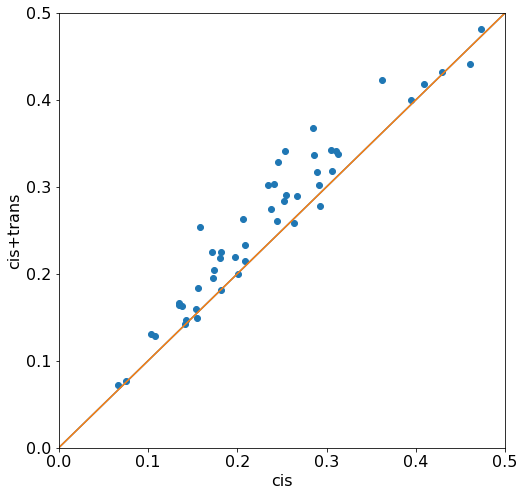

In [146]:
arr = np.loadtxt("anubhav_tmp", )

# with open("anubhav_tmp", 'r') as instream:
#     for line in instream:
#         line.strip().split()

import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 16})


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.scatter(arr[:,1], arr[:,0])
ax.plot([(0,0), (1,1)])
ax.set_xlabel("cis")
ax.set_ylim((0,0.5))
ax.set_xlim((0,0.5))
ax.set_ylabel("cis+trans")
fig.show()

/home/fsimone/myenv/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


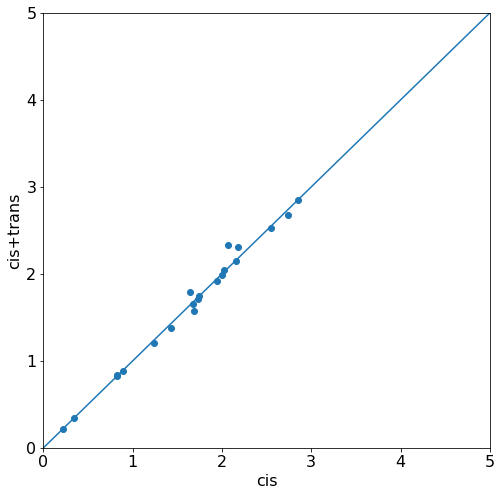

In [155]:
cardio_arr = np.loadtxt("cardio_anubhav_tmp", )

# with open("anubhav_tmp", 'r') as instream:
#     for line in instream:
#         line.strip().split()

import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 16})


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.scatter(-np.log10(cardio_arr[:,1]), -np.log10(cardio_arr[:,0]))
ax.plot([0,5], [0,5])
ax.set_xlabel("cis")
ax.set_ylim((0,5))
ax.set_xlim((0,5))
ax.set_ylabel("cis+trans")
fig.show()